# Self-Driving Car Engineer Nanodegree @Udacity


## Project: **Finding Lane Lines on the Road** 
***
The objective of this project is to identify lane lines on the road, initially on a series of test images and then later on some video streams.

The pipeline I've considered is composed:
* Color selection of the lane lines
* Gray scaling of the images
* Noise reduction with Gaussian blurring
* Edges detection with Canny filter
* Selection of the region of interest
* Lines detection with Hough tranform

Final results of the video processing can be found in the folder [test_videos_output](test_videos_output/):
* Raw lane lines: 
  - [Raw solidWhiteRight.mp4](test_videos_output/solidWhiteRight0.mp4)
  - [Raw solidYellowLeft.mp4](test_videos_output/solidYellowLeft0.mp4)
  
* Full extend of the lane lines: 
  - [solidWhiteRight.mp4](test_videos_output/solidWhiteRight.mp4)
  - [solidYellowLeft.mp4](test_videos_output/solidYellowLeft.mp4)
  
* Challenge lane lines: 
  - [Challenge.mp4](test_videos_output/challenge.mp4)

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


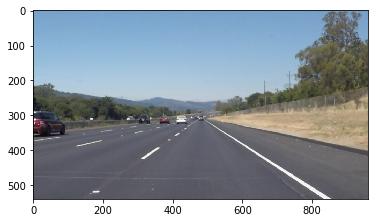

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

Below are some helper functions

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def average_lines(lines):
    """
    Compute the slope and y-intercept of the average left & right lines, 
    weighted by length of indiividula lines.
    """
    if lines is None:
        return [None, None]
    
    sum_weighted_slope = [0, 0]
    sum_weighted_intercept = [0, 0]
    sum_length = [0, 0]
    
    for line in lines:
        if line is None:
            continue
            
        for x1,y1,x2,y2 in line:
            # ignore vertical & horizontal lines
            if x1 == x2 or y1 == y2:
                continue
                
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - slope*x1
            length = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            
            # left lines have negative slopes
            if slope < 0:
                sum_weighted_slope[0] += slope*length
                sum_weighted_intercept[0] += y_intercept*length
                sum_length[0] += length
            else: # Right lines have positive slopes
                sum_weighted_slope[1] += slope*length
                sum_weighted_intercept[1] += y_intercept*length
                sum_length[1] += length
    
    if sum_length[0] != 0 and sum_weighted_slope[0] != 0:
        left_line = (sum_weighted_slope[0]/sum_length[0], sum_weighted_intercept[0]/sum_length[0])
    else:
        left_line = None
    
    if sum_length[1] != 0 and sum_weighted_slope[1] != 0:
        right_line = (sum_weighted_slope[1]/sum_length[1], sum_weighted_intercept[1]/sum_length[1])
    else:
        right_line = None
        
    return [left_line, right_line]
        
            
def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    """    
    This function and draws `the average left & right lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    
    def draw_line(line_data, point1_y, point2_y):
        if line_data is not None:
            slope, intercept = line_data
            point1 = (int((point1_y - intercept)/slope), point1_y)
            point2 = (int((point2_y - intercept)/slope), point2_y)
            
            # Draw the line     
            cv2.line(img, point1, point2, color, thickness)
     
    img_h, img_w, _ = img.shape
    y_factor = img_h / 540
    max_y = img_h
    min_y = int(325 * y_factor)
    
    # Get the average slope & intercept for left and right lines
    left_line, right_line = average_lines(lines)
    
    # Draw left & right lines
    draw_line(left_line, min_y, max_y)
    draw_line(right_line, min_y, max_y)

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Working with Test Images

The pipeline will be build and tested on test images first before processing the video streams.

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Final results of the pipeline on test images will be stored in the folder [test_images_output](test_images_output/).

In [7]:
IMAGE_OUTPUT_PATH = 'test_images_output/'

def show_images(images_data, in_gray=False, img_per_row=3, figsize=(20, 10)):
    """Display images as is or in grey scale. images_data = [(image, name)...]"""
    # images count
    img_cnt = len(images_data)
    
    # show max 3 images per row. Calculate the rows count
    row_cnt = int((img_cnt-1) / img_per_row) + 1
    
    # display the images
    f, axs =  plt.subplots(row_cnt, img_per_row, figsize=figsize)
    count_images = 0
    for r in range(row_cnt):
        for c in range(img_per_row):
            if count_images < img_cnt:
                count_images += 1
                if row_cnt == 1 and img_per_row == 1:
                     ax = axs
                elif row_cnt == 1:
                    ax = axs[c]
                elif img_per_row == 1:
                    ax = axs[r]
                else:
                    ax = axs[r, c]
                cmap = 'gray' if in_gray else None
                ax.set_title(images_data[img_per_row*r + c][1])
                ax.imshow(images_data[img_per_row*r + c][0], cmap=cmap)

                
def save_images(list_images_data, in_gray=False):
    """Save a list of images to disk.
    `list_images_data` is a list of tuple(image, filename)"""
    for (image, filename) in list_images_data: 
        plt.imsave(os.path.join(IMAGE_OUTPUT_PATH, filename), image)


### 1. Let's display the images and have a look at some details of the lanes

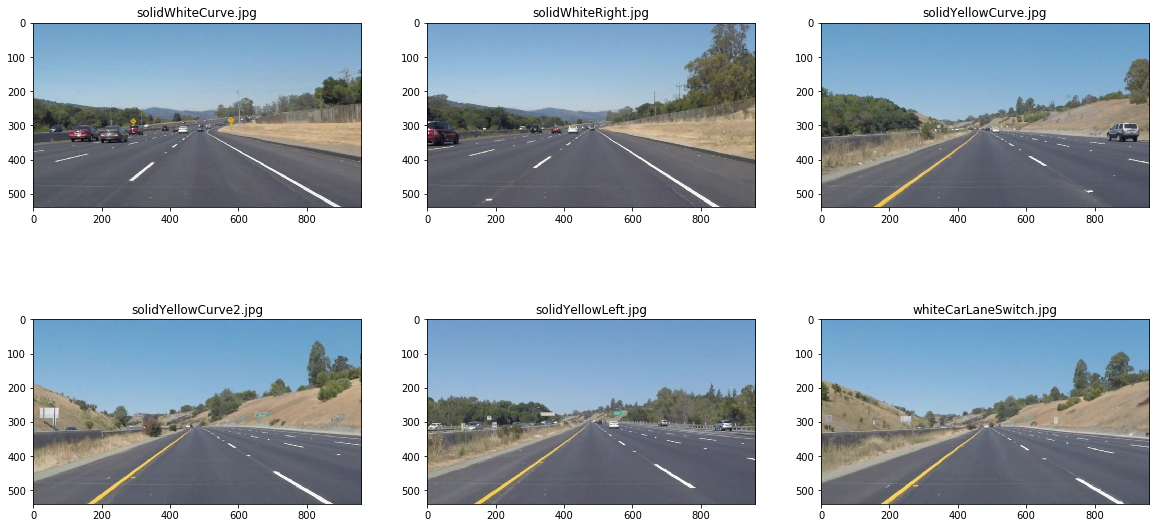

In [10]:
# create list of tuple tuples (test_image, filename) and display them
test_images = [(mpimg.imread(os.path.join("test_images/", file)), file) for file in os.listdir("test_images/")]
show_images(test_images)

### 2. Select only white and yellow colors from the images

In [12]:
HLS_LOW_WHITE = np.array([0, 200, 0])
HLS_UPPER_WHITE = np.array([255,255,255])
HLS_LOW_YELLOW = np.array([10, 0, 100])
HLS_UPPER_YELLOW = np.array([40, 255, 255])  

def white_yellow_selection(image):
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # create mask for white & yellow color
    hls_mask_white = cv2.inRange(hls, HLS_LOW_WHITE, HLS_UPPER_WHITE)
    hls_mask_yellow = cv2.inRange(hls, HLS_LOW_YELLOW, HLS_UPPER_YELLOW)

    image_selection = cv2.bitwise_and(hls, hls, mask=hls_mask_white|hls_mask_yellow)
    image_selection = cv2.cvtColor(image_selection, cv2.COLOR_HLS2RGB)
    
    return image_selection


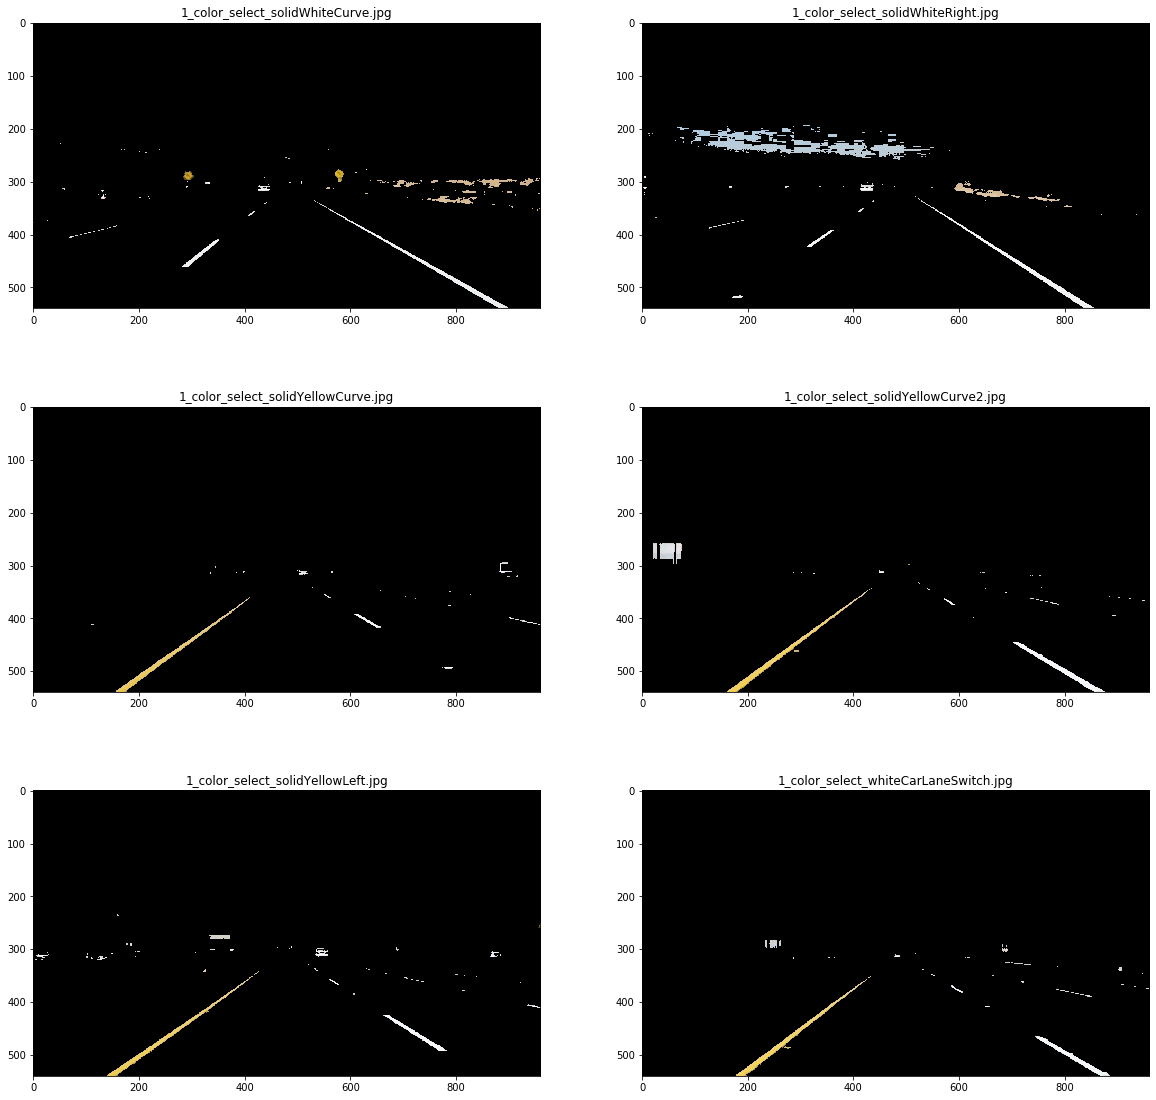

In [14]:
# Select While+Yellow color from all images
white_yellow_test_images = [(white_yellow_selection(image), '1_color_select_'+file) for (image, file) in test_images]
show_images(white_yellow_test_images, img_per_row=2, figsize=(20, 20))
save_images(white_yellow_test_images)

### 3. Generating gray scale images

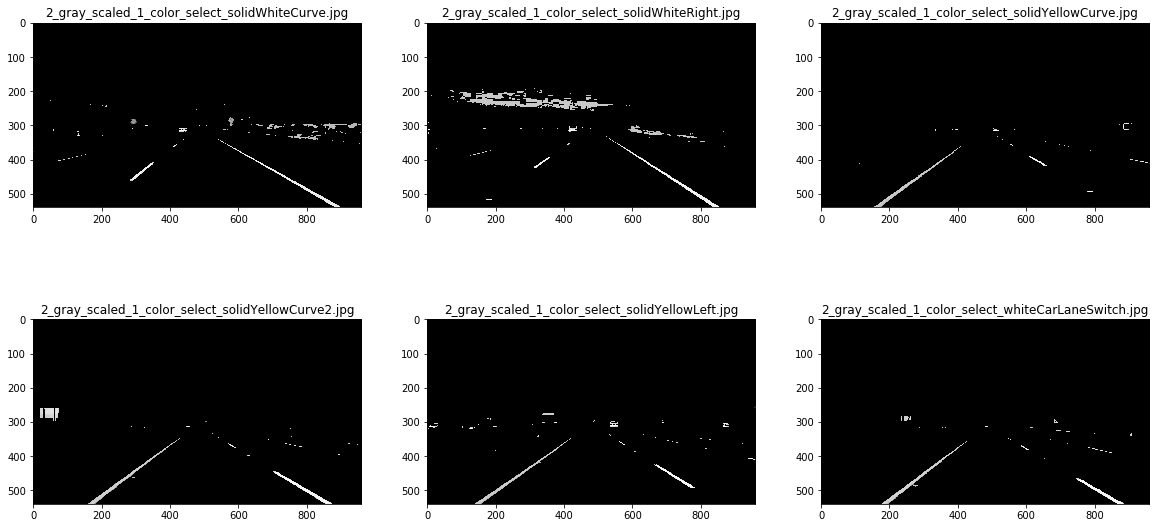

In [16]:
gray_test_images = [(grayscale(image), '2_gray_scaled_'+file) for (image, file) in white_yellow_test_images]
show_images(gray_test_images, img_per_row=3, in_gray=True, figsize=(20, 10))
save_images(gray_test_images)

### 4. Reducing some noise in the grey images with Gaussian blurring

In [17]:
# But first let's play with the kernel_size value to see how different values looks like for our test images
# We will define an interactive function that shows the selected image in original and gaussian blurred format

from ipywidgets import interact, interact_manual

# define interactive range values and step for each parameters:
# - image_id --> value in the range [0, 5], step = 1
# - kernel_size --> value in the range [1, 35], step = 2
@interact(image_id=(0, 5, 1), kernel_size=(1, 35, 2))
def interact_gaussian_blur(image_id=0, kernel_size=5):
    image = gray_test_images[image_id][0]
    title = gray_test_images[image_id][1]
    blur_image = gaussian_blur(image, kernel_size)
    
    images = [(image, 'Gray: ' + title), (blur_image, 'Gaussian Blur: Kernel size is {}'.format(kernel_size))]
    show_images(images, img_per_row=2, in_gray=True, figsize=(20, 20))

interactive(children=(IntSlider(value=0, description='image_id', max=5), IntSlider(value=5, description='kerne…

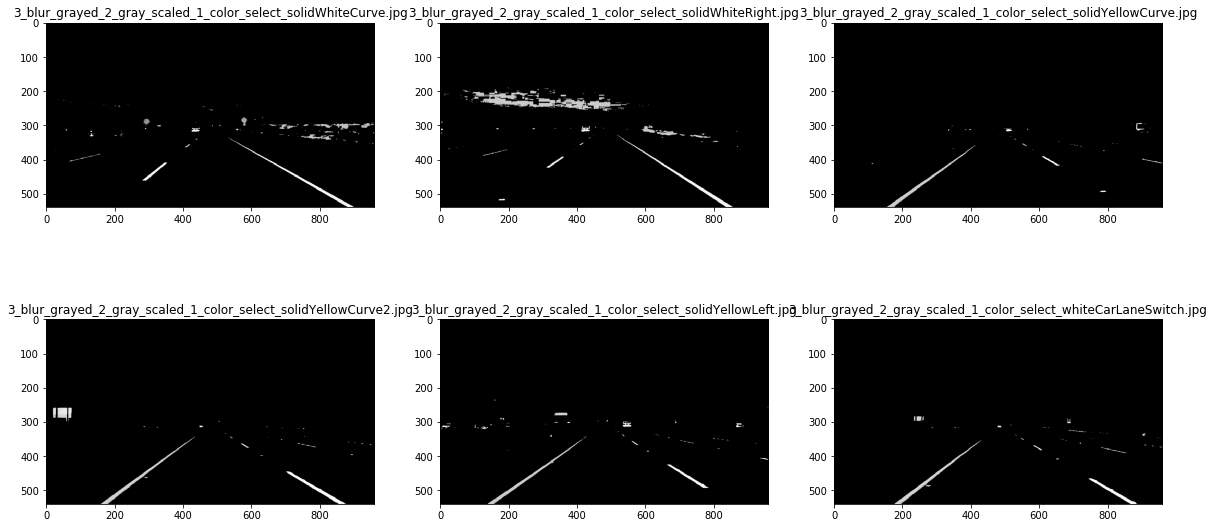

In [18]:
# Value selected after playing with several values from the interactive function define above
kernel_size = 5
blur_gray_test_images = [(gaussian_blur(image, kernel_size), '3_blur_grayed_'+file) for (image, file) in gray_test_images]

show_images(blur_gray_test_images, img_per_row=3, in_gray=True, figsize=(20, 10))
save_images(blur_gray_test_images)

### 4. Now detecting the edges with Canny algorithm

In [19]:
# Again we will first interactively play with the parameters to see what works

from ipywidgets import IntSlider, FloatSlider

ratio_widget = IntSlider(min=2, max=3, step=1, value=3)
low_threshold_widget = IntSlider(min=1, max=int(255/ratio_widget.min), step=1, value=50)

def update_low_threshold_range(*args):
    low_threshold_widget.max = 255 / ratio_widget.value
ratio_widget.observe(update_low_threshold_range, 'value')

# - image_id --> [0, 5], step = 1 (we have 6 test images)
# - ratio --> [2, 3], step = 1 (define the high_threshold/low_threshold ratio of Canny as 2:1 or 3:1)
# - low_threshold --> [1, 255/ratio], step = 1 (high_threshold will be calculated as `ratio * low_threshold`)

@interact(image_id=(0, 5, 1), ratio=ratio_widget, low_threshold=low_threshold_widget, continuous_update=False)
def interact_canny(image_id, ratio, low_threshold):
    image = blur_gray_test_images[image_id][0]
    title = 'Blur Gray: ' + blur_gray_test_images[image_id][1]
    high_threshold = ratio*low_threshold
    title_edges = 'Canny: low_thr is {}, high_thr is {}'.format(low_threshold, high_threshold)
    
    edges = canny(image, low_threshold, high_threshold)
    images = [(gray_test_images[image_id][0], title), (edges, title_edges)]
    show_images(images, img_per_row=1, in_gray=True, figsize=(13, 13))

interactive(children=(IntSlider(value=2, description='image_id', max=5), IntSlider(value=3, description='ratio…

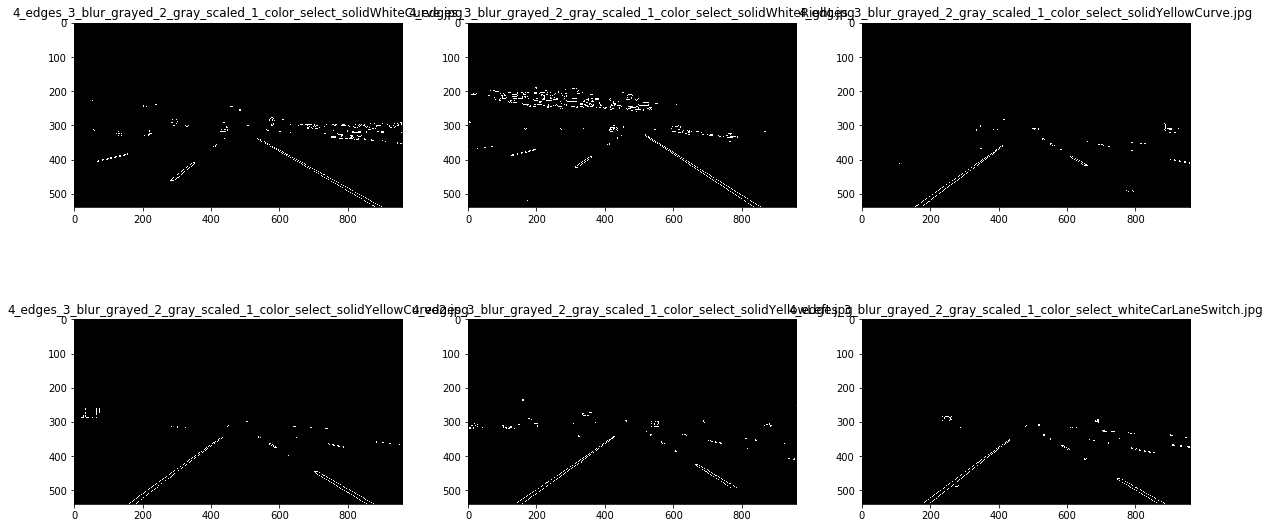

In [20]:
# Value selected after playing with the interactive canny function
low_threshold = 50
high_threshold = 150
edges_test_images = [(canny(image, low_threshold, high_threshold), '4_edges_'+file) for (image, file) in blur_gray_test_images]

show_images(edges_test_images, img_per_row=3, in_gray=True, figsize=(20, 10))
save_images(edges_test_images)

### 5. Definning masked edges image to capture only edges in the area of interest

In [21]:
# Let's use an interactive function to display the selected area of interest

# Get image size
IMG_H, IMG_W = edges_test_images[0][0].shape

# Create the coordinates sliders
wg_l_bottom_x = IntSlider(min=0, max=IMG_W-1, step=1, value=120)  # bottom-left x
wg_l_bottom_y = IntSlider(min=0, max=IMG_H-1, step=1, value=539)  # bottom-left y
wg_l_top_x = IntSlider(min=0, max=IMG_W-1, step=1, value=442)  # top-left x
wg_l_top_y = IntSlider(min=0, max=IMG_H-1, step=1, value=322)  # top-left y
wg_r_top_x = IntSlider(min=0, max=IMG_W-1, step=1, value=520)  # top-right x
wg_r_top_y = IntSlider(min=0, max=IMG_H-1, step=1, value=322)  # top-right y
wg_r_bottom_x = IntSlider(min=0, max=IMG_W-1, step=1, value=926)  # bottom-right x
wg_r_bottom_y = IntSlider(min=0, max=IMG_H-1, step=1, value=539)  # bottom-right y

# define interactive range values and step for each parameters
@interact_manual(image_id=(0, 5, 1), 
          l_bottom_x=wg_l_bottom_x, l_bottom_y=wg_l_bottom_y, l_top_x=wg_l_top_x, l_top_y=wg_l_top_y, 
          r_top_x=wg_r_top_x, r_top_y=wg_r_top_y, r_bottom_x=wg_r_bottom_x, r_bottom_y=wg_r_bottom_y)
def interact_select_area(image_id, l_bottom_x, l_bottom_y, l_top_x, l_top_y, r_top_x, r_top_y, r_bottom_x, r_bottom_y):
    _, ax =  plt.subplots(1, 1, figsize=(20, 20))
    ax.imshow(edges_test_images[image_id][0], cmap='gray')
    ax.set_title(edges_test_images[image_id][1])
    x = [l_bottom_x, l_top_x, r_top_x, r_bottom_x]
    y = [l_bottom_y, l_top_y, r_top_y, r_bottom_y]
    ax.plot(x, y, 'b--', lw=4)
    
# How to use:
# - change the value
# - click on the `Run Interact` button to display

interactive(children=(IntSlider(value=2, description='image_id', max=5), IntSlider(value=120, description='l_b…

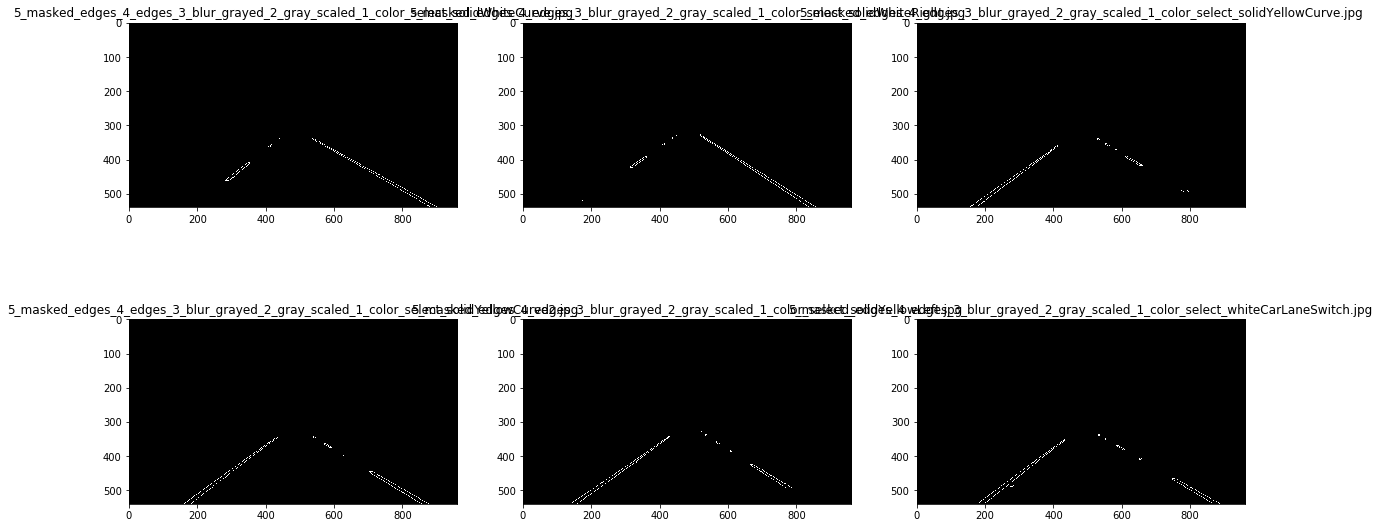

In [22]:
# Value selected after playing with the interactive canny function
vertices = np.array([[(120, IMG_H-1),(442, 322), (520, 322), (926, IMG_H-1)]], dtype=np.int32)
masked_edges_test_images = [(region_of_interest(image, vertices), '5_masked_edges_'+file) for (image, file) in edges_test_images]

show_images(masked_edges_test_images, img_per_row=3, in_gray=True, figsize=(20, 10))
save_images(masked_edges_test_images)

### 6. Dectecting the lines using Hough transformation

In [23]:
# We need to play with the hough tranform parameters to find a good fit
# As usual I will use interactive function for that

# Create the coordinates sliders
wg_rho = IntSlider(min=1, max=10, step=1, value=1)
wg_theta = FloatSlider(min=np.pi/180, max=np.pi, step=np.pi/180, value=np.pi/180)
wg_threshold = IntSlider(min=1, max=100, step=1, value=15) #15
wg_min_line_len = IntSlider(min=1, max=500, step=1, value=20) #40
wg_max_line_gap = IntSlider(min=1, max=500, step=1, value=250) #20

# define interactive range values and step for each parameters
@interact_manual(image_id=(0, 5, 1), 
          rho=wg_rho, theta=wg_theta, threshold=wg_threshold, min_line_len=wg_min_line_len, max_line_gap=wg_max_line_gap)
def interact_hough_lines(image_id, rho, theta, threshold, min_line_len, max_line_gap):
    edges = masked_edges_test_images[image_id][0]
    #title = 'Masked Edge: ' + masked_edges_test_images[image_id][1]
    title = '{}: rho={}, theta={}, thr={}, len={}, gap={}'.format(
        masked_edges_test_images[image_id][1], rho, theta, threshold, min_line_len, max_line_gap)
    
    # Get lines image
    lines_image = hough_lines(edges, rho, theta, threshold, min_line_len, max_line_gap)
    weighted_image = weighted_img(lines_image, test_images[image_id][0])
    
    # Display the result
    #images = [(masked_edges_test_images[image_id][0], title), (weighted_image, title_hough)]
    images = [(weighted_image, title)]
    
    show_images(images, img_per_row=1, in_gray=True, figsize=(20, 20))

interactive(children=(IntSlider(value=2, description='image_id', max=5), IntSlider(value=1, description='rho',…

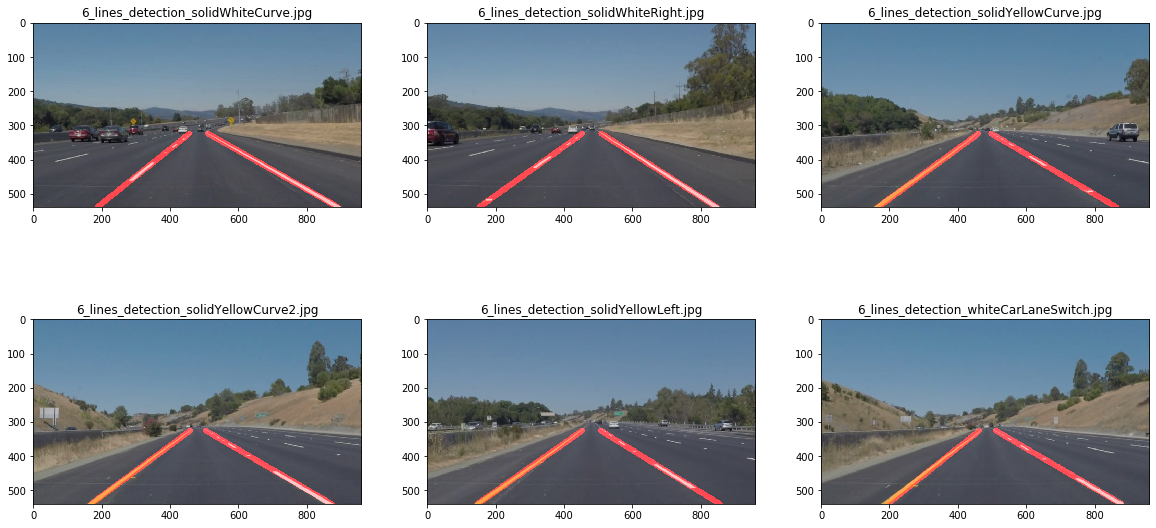

In [26]:
# Value selected after playing with the interactive canny function
args = {'rho':1, 'theta':np.pi/180, 'threshold':15, 'min_line_len':20, 'max_line_gap':250}

lines_on_test_images = [
    (weighted_img(hough_lines(masked_edges_test_images[i][0], **args), test_images[i][0]), '6_lines_detection_'+test_images[i][1])
    for i in range(len(test_images))
]

show_images(lines_on_test_images, img_per_row=3, figsize=(20, 10))
save_images(lines_on_test_images)

## Let's Test the Pipeline on Videos

In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [31]:
def process_image(image):
    """Return final output (image where lines are drawn on lanes).
    The result is a color image (3 channel)"""
    
    # 1. Select white & yellow color only
    white_yellow_image = white_yellow_selection(image)
    
    # 2. Convert image to grey color
    #gray_image = grayscale(image)
    gray_image = grayscale(white_yellow_image)
    
    # 3. Smooth the gray image with gaussian blur
    blur_image = gaussian_blur(gray_image, 5)
    
    # 4. Apply canny filter to detect the edges
    edges_image = canny(blur_image, 50, 150)

    # 5. Apply a mask to get the edges in the region of interest
    img_h, img_w, _ = image.shape
    x_factor = img_w/test_images[0][0].shape[1]
    y_factor = img_h/test_images[0][0].shape[0]
    
    lb_x = int(120*x_factor)
    lb_y = rb_y = img_h-1
    lt_x = int(442*x_factor)
    lt_y = rt_y = int(325 * y_factor)
    rt_x = int(520 * x_factor)
    rb_x = int(926 * x_factor)
    vertices = np.array([[(lb_x, lb_y),(lt_x, lt_y), (rt_x, rt_y), (rb_x, rb_y)]], dtype=np.int32)
    masked_edges_image = region_of_interest(edges_image, vertices)
    
    # 6. Apply Hough Transformation to get the lines
    args = {'rho':1, 'theta':np.pi/180, 'threshold':15, 'min_line_len':20, 'max_line_gap':250}
    lines_image = hough_lines(masked_edges_image, **args)
    result = weighted_img(lines_image, image)
    
    return result


In [32]:
def process_video(input_file, output_file, subclip=None):
    """Run the full Pipeline on the input video file and save the result on output file"""
    if subclip is not None:
        subclip_start, subclip_end = subclip
        clip1 = VideoFileClip(input_file).subclip(subclip_start, subclip_end)
    else:
        clip1 = VideoFileClip(input_file)
        
    processed_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time processed_clip.write_videofile(output_file, audio=False)


#### Run the Pipeline on the image with the solid white lane on the right first ...

In [30]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
process_video('test_videos/solidWhiteRight.mp4', white_output)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 51.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 4.89 s


#### Result is generated in Output folder, also displayed below...

In [21]:
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(white_output))

#### Now for the one with the solid yellow lane on the left...

In [33]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
process_video('test_videos/solidYellowLeft.mp4', yellow_output)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:14<00:00, 48.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 14.8 s


In [23]:
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(yellow_output))

## Optional Challenge

Objective here is to make the pipeline work with the `challenge.mp4` video. Pipeline is already updated, see the results as following.

In [34]:
challenge_output = 'test_videos_output/challenge.mp4'
process_video('test_videos/challenge.mp4', challenge_output)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:08<00:00, 27.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 9.75 s


In [35]:
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(challenge_output))